So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 4

Example of what worked before
Vanilla Gumbel

In [ ]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [ ]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

In [ ]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


In [ ]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

**VAE_Gumbel_NInsta test here**

In [ ]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [ ]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

In [ ]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


In [ ]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

**The new model**


In [12]:
logits_changed_loss_lambda = 0
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = 0.90)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                              lr=lr, 
                                              betas = (b1,b2))



In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      logits_changed_loss_lambda = logits_changed_loss_lambda,
                                                      Dim = 2*D, 
                                                      DEBUG = True)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.005894
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.403408
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.911655
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.281277
Loss tensor(2554.9790, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(2.2118, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.795250
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.336693
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.659637
====> Epoch: 1 Average loss: 40.2669
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.460083
Train Epoch: 2 [1280/8000 (16%)]	Loss: 38.149048
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.289993
Loss tensor(2367.4109, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(14.2797, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.707020
Loss tensor(2318.8369, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(22.5613, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(2307.7639, devic

Train Epoch: 15 [5120/8000 (64%)]	Loss: 32.483093
Loss tensor(2040.5205, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(193.4373, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 15 [6400/8000 (80%)]	Loss: 31.917091
Train Epoch: 15 [7680/8000 (96%)]	Loss: 32.289852
====> Epoch: 15 Average loss: 32.2850
Train Epoch: 16 [0/8000 (0%)]	Loss: 32.191002
Loss tensor(2063.0088, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(224.9011, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 16 [1280/8000 (16%)]	Loss: 31.904879
Train Epoch: 16 [2560/8000 (32%)]	Loss: 31.908775
Train Epoch: 16 [3840/8000 (48%)]	Loss: 32.006447
Train Epoch: 16 [5120/8000 (64%)]	Loss: 31.993176
Train Epoch: 16 [6400/8000 (80%)]	Loss: 32.048378
Loss tensor(2064.6353, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(335.9975, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 16 [7680/8000 (96%)]	Loss: 32.294411
====> Epoch: 16 Average loss: 32.0902
Train Epoch: 17 [0/8

Train Epoch: 31 [3840/8000 (48%)]	Loss: 31.238092
Train Epoch: 31 [5120/8000 (64%)]	Loss: 31.210716
Train Epoch: 31 [6400/8000 (80%)]	Loss: 31.203722
Loss tensor(1970.9165, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(626.3223, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 31 [7680/8000 (96%)]	Loss: 30.469072
====> Epoch: 31 Average loss: 30.8988
Train Epoch: 32 [0/8000 (0%)]	Loss: 30.483698
Loss tensor(1991.4623, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(638.2074, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 32 [1280/8000 (16%)]	Loss: 30.757393
Train Epoch: 32 [2560/8000 (32%)]	Loss: 30.892847
Train Epoch: 32 [3840/8000 (48%)]	Loss: 30.846094
Train Epoch: 32 [5120/8000 (64%)]	Loss: 30.807045
Train Epoch: 32 [6400/8000 (80%)]	Loss: 30.911850
Train Epoch: 32 [7680/8000 (96%)]	Loss: 31.054108
====> Epoch: 32 Average loss: 30.8586
Train Epoch: 33 [0/8000 (0%)]	Loss: 30.795841
Train Epoch: 33 [1280/8000 (16%)]	Loss: 30.765566
Train Epoc

Train Epoch: 46 [6400/8000 (80%)]	Loss: 30.483778
Train Epoch: 46 [7680/8000 (96%)]	Loss: 30.670544
====> Epoch: 46 Average loss: 30.5347
Train Epoch: 47 [0/8000 (0%)]	Loss: 30.314503
Train Epoch: 47 [1280/8000 (16%)]	Loss: 30.375837
Train Epoch: 47 [2560/8000 (32%)]	Loss: 30.545235
Loss tensor(1959.0258, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(716.4166, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 47 [3840/8000 (48%)]	Loss: 31.013294
Train Epoch: 47 [5120/8000 (64%)]	Loss: 30.814672
Train Epoch: 47 [6400/8000 (80%)]	Loss: 30.442041
Train Epoch: 47 [7680/8000 (96%)]	Loss: 30.833576
====> Epoch: 47 Average loss: 30.5167
Train Epoch: 48 [0/8000 (0%)]	Loss: 30.561993
Train Epoch: 48 [1280/8000 (16%)]	Loss: 30.633310
Train Epoch: 48 [2560/8000 (32%)]	Loss: 30.844923
Train Epoch: 48 [3840/8000 (48%)]	Loss: 30.964382
Train Epoch: 48 [5120/8000 (64%)]	Loss: 30.638268
Loss tensor(1941.8373, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(720.7924, devi

Train Epoch: 61 [6400/8000 (80%)]	Loss: 30.573870
Loss tensor(1945.0001, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(701.8715, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 61 [7680/8000 (96%)]	Loss: 30.218060
====> Epoch: 61 Average loss: 30.3713
Train Epoch: 62 [0/8000 (0%)]	Loss: 30.270601
Loss tensor(1946.6039, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(701.8499, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1939.7749, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(698.5843, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 62 [1280/8000 (16%)]	Loss: 30.434690
Train Epoch: 62 [2560/8000 (32%)]	Loss: 30.542582
Train Epoch: 62 [3840/8000 (48%)]	Loss: 30.363226
Train Epoch: 62 [5120/8000 (64%)]	Loss: 30.298567
Train Epoch: 62 [6400/8000 (80%)]	Loss: 30.569963
Train Epoch: 62 [7680/8000 (96%)]	Loss: 30.497553
====> Epoch: 62 Average loss: 30.3700
Train Epoch: 63 [0/8000 (0%)]	Loss: 30.201057
Train Epoch: 63 [1280/80

Loss tensor(1937.5157, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(655.7897, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 76 [2560/8000 (32%)]	Loss: 30.371096
Train Epoch: 76 [3840/8000 (48%)]	Loss: 30.476610
Train Epoch: 76 [5120/8000 (64%)]	Loss: 30.273237
Train Epoch: 76 [6400/8000 (80%)]	Loss: 30.198557
Train Epoch: 76 [7680/8000 (96%)]	Loss: 30.116903
====> Epoch: 76 Average loss: 30.3066
Train Epoch: 77 [0/8000 (0%)]	Loss: 30.373886
Train Epoch: 77 [1280/8000 (16%)]	Loss: 29.924881
Train Epoch: 77 [2560/8000 (32%)]	Loss: 30.378931
Train Epoch: 77 [3840/8000 (48%)]	Loss: 30.057209
Train Epoch: 77 [5120/8000 (64%)]	Loss: 30.419506
Train Epoch: 77 [6400/8000 (80%)]	Loss: 30.050024
Loss tensor(1940.1313, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(663.4603, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 77 [7680/8000 (96%)]	Loss: 30.133621
====> Epoch: 77 Average loss: 30.3036
Train Epoch: 78 [0/8000 (0%)]	Loss: 30.088583
Train Epoc

Train Epoch: 90 [2560/8000 (32%)]	Loss: 30.141520
Train Epoch: 90 [3840/8000 (48%)]	Loss: 30.208429
Train Epoch: 90 [5120/8000 (64%)]	Loss: 30.171877
Train Epoch: 90 [6400/8000 (80%)]	Loss: 30.273438
Loss tensor(1959.6921, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(636.1770, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 90 [7680/8000 (96%)]	Loss: 30.034443
====> Epoch: 90 Average loss: 30.2990
Train Epoch: 91 [0/8000 (0%)]	Loss: 30.175894
Train Epoch: 91 [1280/8000 (16%)]	Loss: 30.538231
Train Epoch: 91 [2560/8000 (32%)]	Loss: 30.319336
Train Epoch: 91 [3840/8000 (48%)]	Loss: 30.639622
Train Epoch: 91 [5120/8000 (64%)]	Loss: 30.078983
Train Epoch: 91 [6400/8000 (80%)]	Loss: 30.198975
Train Epoch: 91 [7680/8000 (96%)]	Loss: 30.229504
====> Epoch: 91 Average loss: 30.3068
Train Epoch: 92 [0/8000 (0%)]	Loss: 30.210400
Loss tensor(1951.3401, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(635.0835, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoc

Train Epoch: 104 [5120/8000 (64%)]	Loss: 30.267235
Train Epoch: 104 [6400/8000 (80%)]	Loss: 30.154779
Loss tensor(1935.2325, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(645.6372, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 104 [7680/8000 (96%)]	Loss: 30.300640
====> Epoch: 104 Average loss: 30.2953
Train Epoch: 105 [0/8000 (0%)]	Loss: 30.447794
Train Epoch: 105 [1280/8000 (16%)]	Loss: 30.137058
Loss tensor(1912.7365, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(655.6311, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 105 [2560/8000 (32%)]	Loss: 30.103338
Train Epoch: 105 [3840/8000 (48%)]	Loss: 30.382751
Train Epoch: 105 [5120/8000 (64%)]	Loss: 30.200260
Train Epoch: 105 [6400/8000 (80%)]	Loss: 30.436899
Train Epoch: 105 [7680/8000 (96%)]	Loss: 30.203049
====> Epoch: 105 Average loss: 30.2876
Train Epoch: 106 [0/8000 (0%)]	Loss: 29.842510
Train Epoch: 106 [1280/8000 (16%)]	Loss: 30.469685
Train Epoch: 106 [2560/8000 (32%)]	Loss: 30.37

Train Epoch: 119 [1280/8000 (16%)]	Loss: 30.293501
Train Epoch: 119 [2560/8000 (32%)]	Loss: 30.350134
Train Epoch: 119 [3840/8000 (48%)]	Loss: 29.885437
Train Epoch: 119 [5120/8000 (64%)]	Loss: 30.108078
Loss tensor(1921.5170, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(657.6395, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 119 [6400/8000 (80%)]	Loss: 30.194677
Train Epoch: 119 [7680/8000 (96%)]	Loss: 30.004494
====> Epoch: 119 Average loss: 30.2816
Train Epoch: 120 [0/8000 (0%)]	Loss: 29.977474
Train Epoch: 120 [1280/8000 (16%)]	Loss: 30.265638
Train Epoch: 120 [2560/8000 (32%)]	Loss: 30.449884
Train Epoch: 120 [3840/8000 (48%)]	Loss: 30.186409
Train Epoch: 120 [5120/8000 (64%)]	Loss: 30.342670
Train Epoch: 120 [6400/8000 (80%)]	Loss: 30.483631
Train Epoch: 120 [7680/8000 (96%)]	Loss: 30.218395
====> Epoch: 120 Average loss: 30.2777
Train Epoch: 121 [0/8000 (0%)]	Loss: 30.115330
Train Epoch: 121 [1280/8000 (16%)]	Loss: 30.428734
Train Epoch: 121 [2560/8000 (

Train Epoch: 133 [7680/8000 (96%)]	Loss: 30.117626
====> Epoch: 133 Average loss: 30.2463
Train Epoch: 134 [0/8000 (0%)]	Loss: 30.373518
Train Epoch: 134 [1280/8000 (16%)]	Loss: 30.107586
Train Epoch: 134 [2560/8000 (32%)]	Loss: 30.522360
Train Epoch: 134 [3840/8000 (48%)]	Loss: 30.042023
Loss tensor(1925.4126, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(697.4074, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 134 [5120/8000 (64%)]	Loss: 30.430143
Train Epoch: 134 [6400/8000 (80%)]	Loss: 30.544811
Train Epoch: 134 [7680/8000 (96%)]	Loss: 30.043188
====> Epoch: 134 Average loss: 30.2721
Train Epoch: 135 [0/8000 (0%)]	Loss: 30.523899
Train Epoch: 135 [1280/8000 (16%)]	Loss: 30.208305
Train Epoch: 135 [2560/8000 (32%)]	Loss: 30.144720
Train Epoch: 135 [3840/8000 (48%)]	Loss: 29.887394
Train Epoch: 135 [5120/8000 (64%)]	Loss: 30.283993
Loss tensor(1930.2827, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(692.3483, device='cuda:0', grad_fn=<MseLossBackwa

Train Epoch: 149 [5120/8000 (64%)]	Loss: 30.345293
Loss tensor(1934.9355, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(771.5923, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 149 [6400/8000 (80%)]	Loss: 30.184240
Train Epoch: 149 [7680/8000 (96%)]	Loss: 30.336370
====> Epoch: 149 Average loss: 30.2304
Train Epoch: 150 [0/8000 (0%)]	Loss: 29.892378
Train Epoch: 150 [1280/8000 (16%)]	Loss: 30.539679
Train Epoch: 150 [2560/8000 (32%)]	Loss: 30.210812
Loss tensor(1952.8275, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(788.1963, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.929457
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.997778
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.377636
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.319044
====> Epoch: 150 Average loss: 30.2597
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.277872
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.096237
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.31

Train Epoch: 163 [2560/8000 (32%)]	Loss: 29.872269
Loss tensor(1941.2703, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(899.7646, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 163 [3840/8000 (48%)]	Loss: 30.619692
Train Epoch: 163 [5120/8000 (64%)]	Loss: 29.935865
Train Epoch: 163 [6400/8000 (80%)]	Loss: 30.458591
Loss tensor(1942.6326, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(906.1521, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 163 [7680/8000 (96%)]	Loss: 30.266562
====> Epoch: 163 Average loss: 30.2320
Train Epoch: 164 [0/8000 (0%)]	Loss: 30.204062
Train Epoch: 164 [1280/8000 (16%)]	Loss: 30.142086
Train Epoch: 164 [2560/8000 (32%)]	Loss: 30.444914
Train Epoch: 164 [3840/8000 (48%)]	Loss: 30.064056
Train Epoch: 164 [5120/8000 (64%)]	Loss: 30.039015
Train Epoch: 164 [6400/8000 (80%)]	Loss: 30.487152
Train Epoch: 164 [7680/8000 (96%)]	Loss: 30.269753
====> Epoch: 164 Average loss: 30.2415
Train Epoch: 165 [0/8000 (0%)]	Loss: 30.23

Loss tensor(1956.0244, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(978.3880, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 176 [6400/8000 (80%)]	Loss: 30.326506
Train Epoch: 176 [7680/8000 (96%)]	Loss: 30.384596
====> Epoch: 176 Average loss: 30.2415
Train Epoch: 177 [0/8000 (0%)]	Loss: 30.497307
Train Epoch: 177 [1280/8000 (16%)]	Loss: 30.398623
Train Epoch: 177 [2560/8000 (32%)]	Loss: 30.511187
Train Epoch: 177 [3840/8000 (48%)]	Loss: 30.364887
Train Epoch: 177 [5120/8000 (64%)]	Loss: 30.205818
Train Epoch: 177 [6400/8000 (80%)]	Loss: 30.305574
Train Epoch: 177 [7680/8000 (96%)]	Loss: 29.939323
====> Epoch: 177 Average loss: 30.2395
Train Epoch: 178 [0/8000 (0%)]	Loss: 30.341686
Train Epoch: 178 [1280/8000 (16%)]	Loss: 30.237795
Loss tensor(1928.2671, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(984.5076, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 178 [2560/8000 (32%)]	Loss: 30.267153
Train Epoch: 178 [3840/8000 (48%)]	Loss: 30.33

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.157478
Loss tensor(1932.8217, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(940.3632, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.426603
Loss tensor(1927.6677, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(937.8827, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.597786
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.182104
====> Epoch: 192 Average loss: 30.2187
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.199282
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.182293
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.330584
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.441896
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.153681
Train Epoch: 193 [6400/8000 (80%)]	Loss: 30.229630
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.312428
====> Epoch: 193 Average loss: 30.2177
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.354300
Train Epoch: 194 [1280/8000 (16%)]	Loss: 29.86

Train Epoch: 205 [2560/8000 (32%)]	Loss: 30.141235
Train Epoch: 205 [3840/8000 (48%)]	Loss: 30.751143
Train Epoch: 205 [5120/8000 (64%)]	Loss: 30.122019
Loss tensor(1941.4021, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(900.5050, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 205 [6400/8000 (80%)]	Loss: 30.334408
Train Epoch: 205 [7680/8000 (96%)]	Loss: 30.477596
====> Epoch: 205 Average loss: 30.2369
Train Epoch: 206 [0/8000 (0%)]	Loss: 30.171154
Loss tensor(1939.4956, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(893.2966, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1926.1981, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(894.2764, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 206 [1280/8000 (16%)]	Loss: 29.983736
Loss tensor(1931.1654, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(896.6805, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 206 [2560/8000 (32%)]	Loss: 30.199753
Train Epoch: 

Train Epoch: 220 [6400/8000 (80%)]	Loss: 30.437637
Train Epoch: 220 [7680/8000 (96%)]	Loss: 30.389069
====> Epoch: 220 Average loss: 30.2125
Train Epoch: 221 [0/8000 (0%)]	Loss: 30.112547
Loss tensor(1926.1881, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(849.7743, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 221 [1280/8000 (16%)]	Loss: 30.093647
Train Epoch: 221 [2560/8000 (32%)]	Loss: 30.263144
Train Epoch: 221 [3840/8000 (48%)]	Loss: 30.293217
Loss tensor(1942.7620, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(846.6974, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 221 [5120/8000 (64%)]	Loss: 30.279497
Train Epoch: 221 [6400/8000 (80%)]	Loss: 30.602644
Train Epoch: 221 [7680/8000 (96%)]	Loss: 30.262640
====> Epoch: 221 Average loss: 30.2246
Train Epoch: 222 [0/8000 (0%)]	Loss: 30.013979
Train Epoch: 222 [1280/8000 (16%)]	Loss: 30.156506
Train Epoch: 222 [2560/8000 (32%)]	Loss: 30.275339
Train Epoch: 222 [3840/8000 (48%)]	Loss: 30.34

Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.112411
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.367001
Train Epoch: 235 [7680/8000 (96%)]	Loss: 29.792269
====> Epoch: 235 Average loss: 30.2162
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.275410
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.417864
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.217501
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.608110
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.244062
Train Epoch: 236 [6400/8000 (80%)]	Loss: 29.908197
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.254759
====> Epoch: 236 Average loss: 30.2333
Train Epoch: 237 [0/8000 (0%)]	Loss: 30.310316
Train Epoch: 237 [1280/8000 (16%)]	Loss: 30.328295
Train Epoch: 237 [2560/8000 (32%)]	Loss: 30.541513
Train Epoch: 237 [3840/8000 (48%)]	Loss: 29.883371
Train Epoch: 237 [5120/8000 (64%)]	Loss: 30.136684
Train Epoch: 237 [6400/8000 (80%)]	Loss: 30.333805
Loss tensor(1918.9115, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(848.0208, device='cuda:0', grad_

Train Epoch: 251 [1280/8000 (16%)]	Loss: 30.604284
Train Epoch: 251 [2560/8000 (32%)]	Loss: 30.439838
Train Epoch: 251 [3840/8000 (48%)]	Loss: 30.398069
Train Epoch: 251 [5120/8000 (64%)]	Loss: 30.083801
Train Epoch: 251 [6400/8000 (80%)]	Loss: 30.186466
Train Epoch: 251 [7680/8000 (96%)]	Loss: 30.250629
====> Epoch: 251 Average loss: 30.2410
Train Epoch: 252 [0/8000 (0%)]	Loss: 30.152929
Train Epoch: 252 [1280/8000 (16%)]	Loss: 30.570299
Loss tensor(1963.9041, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(851.9352, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 252 [2560/8000 (32%)]	Loss: 29.726429
Train Epoch: 252 [3840/8000 (48%)]	Loss: 30.351229
Train Epoch: 252 [5120/8000 (64%)]	Loss: 30.206125
Loss tensor(1947.7992, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(849.4653, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 252 [6400/8000 (80%)]	Loss: 29.975332
Loss tensor(1939.6611, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor

Train Epoch: 264 [7680/8000 (96%)]	Loss: 30.161661
====> Epoch: 264 Average loss: 30.2234
Train Epoch: 265 [0/8000 (0%)]	Loss: 30.655792
Train Epoch: 265 [1280/8000 (16%)]	Loss: 30.443710
Train Epoch: 265 [2560/8000 (32%)]	Loss: 30.014900
Train Epoch: 265 [3840/8000 (48%)]	Loss: 30.355537
Train Epoch: 265 [5120/8000 (64%)]	Loss: 30.059919
Train Epoch: 265 [6400/8000 (80%)]	Loss: 30.208008
Train Epoch: 265 [7680/8000 (96%)]	Loss: 30.196247
====> Epoch: 265 Average loss: 30.2192
Train Epoch: 266 [0/8000 (0%)]	Loss: 30.274740
Train Epoch: 266 [1280/8000 (16%)]	Loss: 30.329647
Loss tensor(1966.7365, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(878.1136, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 266 [2560/8000 (32%)]	Loss: 30.374557
Train Epoch: 266 [3840/8000 (48%)]	Loss: 29.922493
Train Epoch: 266 [5120/8000 (64%)]	Loss: 30.127111
Train Epoch: 266 [6400/8000 (80%)]	Loss: 30.175995
Train Epoch: 266 [7680/8000 (96%)]	Loss: 30.416454
====> Epoch: 266 Average loss

Train Epoch: 280 [5120/8000 (64%)]	Loss: 29.864054
Train Epoch: 280 [6400/8000 (80%)]	Loss: 30.044102
Train Epoch: 280 [7680/8000 (96%)]	Loss: 29.688940
====> Epoch: 280 Average loss: 30.1817
Train Epoch: 281 [0/8000 (0%)]	Loss: 30.230532
Train Epoch: 281 [1280/8000 (16%)]	Loss: 30.446821
Train Epoch: 281 [2560/8000 (32%)]	Loss: 30.010767
Train Epoch: 281 [3840/8000 (48%)]	Loss: 30.349386
Loss tensor(1934.0614, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1032.5482, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1941.5803, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1028.4717, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 281 [5120/8000 (64%)]	Loss: 30.326490
Train Epoch: 281 [6400/8000 (80%)]	Loss: 30.090363
Train Epoch: 281 [7680/8000 (96%)]	Loss: 30.151628
====> Epoch: 281 Average loss: 30.1819
Train Epoch: 282 [0/8000 (0%)]	Loss: 30.077501
Train Epoch: 282 [1280/8000 (16%)]	Loss: 29.942728
Train Epoch: 282 [2560/8000 (32%)]	Loss: 30.

Train Epoch: 295 [5120/8000 (64%)]	Loss: 30.063490
Train Epoch: 295 [6400/8000 (80%)]	Loss: 30.357029
Train Epoch: 295 [7680/8000 (96%)]	Loss: 29.834789
====> Epoch: 295 Average loss: 30.1681
Train Epoch: 296 [0/8000 (0%)]	Loss: 30.301929
Train Epoch: 296 [1280/8000 (16%)]	Loss: 30.054169
Train Epoch: 296 [2560/8000 (32%)]	Loss: 30.163149
Train Epoch: 296 [3840/8000 (48%)]	Loss: 30.458941
Train Epoch: 296 [5120/8000 (64%)]	Loss: 30.034525
Train Epoch: 296 [6400/8000 (80%)]	Loss: 30.278130
Train Epoch: 296 [7680/8000 (96%)]	Loss: 30.128193
====> Epoch: 296 Average loss: 30.1541
Train Epoch: 297 [0/8000 (0%)]	Loss: 30.348122
Loss tensor(1942.7917, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1207.6609, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1927.1407, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1210.8983, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 297 [1280/8000 (16%)]	Loss: 30.283661
Loss tensor(1941.9163, device='cuda:0', grad

Train Epoch: 309 [6400/8000 (80%)]	Loss: 29.836746
Train Epoch: 309 [7680/8000 (96%)]	Loss: 29.973015
====> Epoch: 309 Average loss: 30.1560
Train Epoch: 310 [0/8000 (0%)]	Loss: 30.114807
Train Epoch: 310 [1280/8000 (16%)]	Loss: 29.830408
Loss tensor(1933.0562, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1262.7321, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 310 [2560/8000 (32%)]	Loss: 30.004347
Train Epoch: 310 [3840/8000 (48%)]	Loss: 30.120556
Train Epoch: 310 [5120/8000 (64%)]	Loss: 30.090136
Train Epoch: 310 [6400/8000 (80%)]	Loss: 30.157829
Train Epoch: 310 [7680/8000 (96%)]	Loss: 30.281628
====> Epoch: 310 Average loss: 30.1460
Train Epoch: 311 [0/8000 (0%)]	Loss: 30.134666
Train Epoch: 311 [1280/8000 (16%)]	Loss: 30.174507
Train Epoch: 311 [2560/8000 (32%)]	Loss: 29.852432
Train Epoch: 311 [3840/8000 (48%)]	Loss: 30.030617
Train Epoch: 311 [5120/8000 (64%)]	Loss: 30.175270
Train Epoch: 311 [6400/8000 (80%)]	Loss: 30.242323
Train Epoch: 311 [7680/8000 

Train Epoch: 321 [5120/8000 (64%)]	Loss: 30.388941
Loss tensor(1928.8901, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1383.2083, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 321 [6400/8000 (80%)]	Loss: 30.107054
Train Epoch: 321 [7680/8000 (96%)]	Loss: 30.163315
====> Epoch: 321 Average loss: 30.1087
Train Epoch: 322 [0/8000 (0%)]	Loss: 29.978451
Train Epoch: 322 [1280/8000 (16%)]	Loss: 29.908657
Train Epoch: 322 [2560/8000 (32%)]	Loss: 29.851349
Train Epoch: 322 [3840/8000 (48%)]	Loss: 29.843904
Train Epoch: 322 [5120/8000 (64%)]	Loss: 30.028360
Train Epoch: 322 [6400/8000 (80%)]	Loss: 30.355761
Train Epoch: 322 [7680/8000 (96%)]	Loss: 30.078915
====> Epoch: 322 Average loss: 30.1353
Train Epoch: 323 [0/8000 (0%)]	Loss: 30.175564
Train Epoch: 323 [1280/8000 (16%)]	Loss: 29.824921
Train Epoch: 323 [2560/8000 (32%)]	Loss: 30.164488
Train Epoch: 323 [3840/8000 (48%)]	Loss: 30.134319
Train Epoch: 323 [5120/8000 (64%)]	Loss: 30.107796
Train Epoch: 323 [6400/8000 

Train Epoch: 335 [6400/8000 (80%)]	Loss: 29.937222
Loss tensor(1928.4050, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1475.5339, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 335 [7680/8000 (96%)]	Loss: 30.131329
====> Epoch: 335 Average loss: 30.1111
Train Epoch: 336 [0/8000 (0%)]	Loss: 30.292023
Train Epoch: 336 [1280/8000 (16%)]	Loss: 29.852264
Train Epoch: 336 [2560/8000 (32%)]	Loss: 29.827929
Train Epoch: 336 [3840/8000 (48%)]	Loss: 29.765379
Train Epoch: 336 [5120/8000 (64%)]	Loss: 30.225393
Loss tensor(1917.3633, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1471.8630, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 336 [6400/8000 (80%)]	Loss: 30.516186
Train Epoch: 336 [7680/8000 (96%)]	Loss: 29.959908
====> Epoch: 336 Average loss: 30.1138
Train Epoch: 337 [0/8000 (0%)]	Loss: 30.169031
Train Epoch: 337 [1280/8000 (16%)]	Loss: 29.975405
Train Epoch: 337 [2560/8000 (32%)]	Loss: 29.859886
Train Epoch: 337 [3840/8000 (48%)]	Loss: 30.

Train Epoch: 350 [6400/8000 (80%)]	Loss: 30.108925
Train Epoch: 350 [7680/8000 (96%)]	Loss: 30.258886
====> Epoch: 350 Average loss: 30.0949
Train Epoch: 351 [0/8000 (0%)]	Loss: 30.807604
Train Epoch: 351 [1280/8000 (16%)]	Loss: 30.007023
Train Epoch: 351 [2560/8000 (32%)]	Loss: 29.996511
Train Epoch: 351 [3840/8000 (48%)]	Loss: 30.276722
Loss tensor(1921.8145, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1454.3862, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 351 [5120/8000 (64%)]	Loss: 30.198034
Train Epoch: 351 [6400/8000 (80%)]	Loss: 30.352083
Train Epoch: 351 [7680/8000 (96%)]	Loss: 29.829096
====> Epoch: 351 Average loss: 30.1079
Train Epoch: 352 [0/8000 (0%)]	Loss: 29.802042
Train Epoch: 352 [1280/8000 (16%)]	Loss: 29.957630
Loss tensor(1930.9742, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1474.2903, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 352 [2560/8000 (32%)]	Loss: 30.051308
Loss tensor(1925.3994, device='cuda:0', grad

Loss tensor(1927.0688, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1437.9586, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 363 [5120/8000 (64%)]	Loss: 30.336346
Train Epoch: 363 [6400/8000 (80%)]	Loss: 30.266354
Train Epoch: 363 [7680/8000 (96%)]	Loss: 30.016228
====> Epoch: 363 Average loss: 30.0792
Train Epoch: 364 [0/8000 (0%)]	Loss: 30.156174
Train Epoch: 364 [1280/8000 (16%)]	Loss: 30.042982
Train Epoch: 364 [2560/8000 (32%)]	Loss: 29.948626
Train Epoch: 364 [3840/8000 (48%)]	Loss: 30.504490
Train Epoch: 364 [5120/8000 (64%)]	Loss: 29.978651
Loss tensor(1932.8716, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1436.0111, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 364 [6400/8000 (80%)]	Loss: 29.982264
Train Epoch: 364 [7680/8000 (96%)]	Loss: 30.372408
====> Epoch: 364 Average loss: 30.0701
Train Epoch: 365 [0/8000 (0%)]	Loss: 30.435780
Loss tensor(1921.7590, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1445.5000, de

Train Epoch: 376 [3840/8000 (48%)]	Loss: 29.856121
Train Epoch: 376 [5120/8000 (64%)]	Loss: 30.390253
Train Epoch: 376 [6400/8000 (80%)]	Loss: 30.141178
Train Epoch: 376 [7680/8000 (96%)]	Loss: 29.957743
====> Epoch: 376 Average loss: 30.0648
Train Epoch: 377 [0/8000 (0%)]	Loss: 29.827236
Train Epoch: 377 [1280/8000 (16%)]	Loss: 29.973572
Train Epoch: 377 [2560/8000 (32%)]	Loss: 29.954578
Train Epoch: 377 [3840/8000 (48%)]	Loss: 30.229126
Train Epoch: 377 [5120/8000 (64%)]	Loss: 29.565790
Train Epoch: 377 [6400/8000 (80%)]	Loss: 30.226675
Loss tensor(1941.2590, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1451.2068, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 377 [7680/8000 (96%)]	Loss: 30.089273
====> Epoch: 377 Average loss: 30.0597
Train Epoch: 378 [0/8000 (0%)]	Loss: 30.230671
Train Epoch: 378 [1280/8000 (16%)]	Loss: 29.753273
Train Epoch: 378 [2560/8000 (32%)]	Loss: 30.230064
Train Epoch: 378 [3840/8000 (48%)]	Loss: 30.470480
Train Epoch: 378 [5120/8000 

Train Epoch: 390 [3840/8000 (48%)]	Loss: 30.246290
Train Epoch: 390 [5120/8000 (64%)]	Loss: 30.149406
Train Epoch: 390 [6400/8000 (80%)]	Loss: 30.088943
Train Epoch: 390 [7680/8000 (96%)]	Loss: 30.186525
====> Epoch: 390 Average loss: 30.0545
Train Epoch: 391 [0/8000 (0%)]	Loss: 30.031940
Loss tensor(1918.6907, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1538.4744, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 391 [1280/8000 (16%)]	Loss: 30.083807
Train Epoch: 391 [2560/8000 (32%)]	Loss: 29.904039
Loss tensor(1922.9723, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1559.2587, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 391 [3840/8000 (48%)]	Loss: 29.659920
Train Epoch: 391 [5120/8000 (64%)]	Loss: 30.145716
Train Epoch: 391 [6400/8000 (80%)]	Loss: 29.899118
Train Epoch: 391 [7680/8000 (96%)]	Loss: 30.005611
====> Epoch: 391 Average loss: 30.0447
Train Epoch: 392 [0/8000 (0%)]	Loss: 29.823132
Train Epoch: 392 [1280/8000 (16%)]	Loss: 29.

Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.072390
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.124945
Train Epoch: 403 [5120/8000 (64%)]	Loss: 29.812243
Train Epoch: 403 [6400/8000 (80%)]	Loss: 29.783028
Train Epoch: 403 [7680/8000 (96%)]	Loss: 29.943613
====> Epoch: 403 Average loss: 30.0265
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.103134
Train Epoch: 404 [1280/8000 (16%)]	Loss: 29.712732
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.223459
Loss tensor(1911.3713, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1556.9385, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.087978
Loss tensor(1934.6918, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1558.4597, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.102516
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.684732
Loss tensor(1926.3444, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1554.7036, device='cuda:0', grad_fn=<MseLossBack

Loss tensor(1928.0397, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1659.8674, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 416 [2560/8000 (32%)]	Loss: 29.911106
Train Epoch: 416 [3840/8000 (48%)]	Loss: 30.151022
Train Epoch: 416 [5120/8000 (64%)]	Loss: 30.173594
Train Epoch: 416 [6400/8000 (80%)]	Loss: 30.034613
Train Epoch: 416 [7680/8000 (96%)]	Loss: 29.875360
====> Epoch: 416 Average loss: 30.0141
Train Epoch: 417 [0/8000 (0%)]	Loss: 30.241653
Train Epoch: 417 [1280/8000 (16%)]	Loss: 30.276260
Train Epoch: 417 [2560/8000 (32%)]	Loss: 29.957531
Loss tensor(1928.8379, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1647.2056, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 417 [3840/8000 (48%)]	Loss: 30.043751
Train Epoch: 417 [5120/8000 (64%)]	Loss: 30.027353
Train Epoch: 417 [6400/8000 (80%)]	Loss: 29.703417
Loss tensor(1928.6111, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1641.5720, device='cuda:0', grad_fn=<MseLossBack

Train Epoch: 430 [2560/8000 (32%)]	Loss: 29.738729
Train Epoch: 430 [3840/8000 (48%)]	Loss: 29.428495
Train Epoch: 430 [5120/8000 (64%)]	Loss: 30.016895
Train Epoch: 430 [6400/8000 (80%)]	Loss: 30.322601
Train Epoch: 430 [7680/8000 (96%)]	Loss: 30.243361
====> Epoch: 430 Average loss: 29.9806
Train Epoch: 431 [0/8000 (0%)]	Loss: 30.095381
Train Epoch: 431 [1280/8000 (16%)]	Loss: 29.858501
Train Epoch: 431 [2560/8000 (32%)]	Loss: 30.551456
Train Epoch: 431 [3840/8000 (48%)]	Loss: 30.058287
Train Epoch: 431 [5120/8000 (64%)]	Loss: 29.629873
Loss tensor(1918.5139, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1663.6924, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 431 [6400/8000 (80%)]	Loss: 29.974167
Train Epoch: 431 [7680/8000 (96%)]	Loss: 29.990101
====> Epoch: 431 Average loss: 30.0059
Train Epoch: 432 [0/8000 (0%)]	Loss: 30.057709
Loss tensor(1928.0227, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1678.8406, device='cuda:0', grad_fn=<MseLossBack

Train Epoch: 444 [1280/8000 (16%)]	Loss: 30.259964
Train Epoch: 444 [2560/8000 (32%)]	Loss: 30.025505
Train Epoch: 444 [3840/8000 (48%)]	Loss: 30.039732
Loss tensor(1930.0923, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1685.6833, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 444 [5120/8000 (64%)]	Loss: 29.818766
Train Epoch: 444 [6400/8000 (80%)]	Loss: 29.738861
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.826227
====> Epoch: 444 Average loss: 29.9751
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.710222
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.034163
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.233360
Train Epoch: 445 [3840/8000 (48%)]	Loss: 29.941051
Train Epoch: 445 [5120/8000 (64%)]	Loss: 30.013866
Train Epoch: 445 [6400/8000 (80%)]	Loss: 30.019630
Train Epoch: 445 [7680/8000 (96%)]	Loss: 29.767769
====> Epoch: 445 Average loss: 29.9706
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.065567
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.140141
Train Epoch: 446 [2560/8000 

Train Epoch: 459 [3840/8000 (48%)]	Loss: 29.911745
Train Epoch: 459 [5120/8000 (64%)]	Loss: 29.898811
Train Epoch: 459 [6400/8000 (80%)]	Loss: 30.037510
Train Epoch: 459 [7680/8000 (96%)]	Loss: 30.124342
====> Epoch: 459 Average loss: 29.9529
Train Epoch: 460 [0/8000 (0%)]	Loss: 30.011002
Train Epoch: 460 [1280/8000 (16%)]	Loss: 29.860279
Loss tensor(1911.6289, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1711.0360, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 460 [2560/8000 (32%)]	Loss: 29.779577
Train Epoch: 460 [3840/8000 (48%)]	Loss: 29.707998
Train Epoch: 460 [5120/8000 (64%)]	Loss: 29.851313
Loss tensor(1917.8058, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1721.6252, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 460 [6400/8000 (80%)]	Loss: 29.965715
Train Epoch: 460 [7680/8000 (96%)]	Loss: 29.582836
====> Epoch: 460 Average loss: 29.9400
Train Epoch: 461 [0/8000 (0%)]	Loss: 29.922255
Train Epoch: 461 [1280/8000 (16%)]	Loss: 29.

Train Epoch: 474 [1280/8000 (16%)]	Loss: 30.013443
Train Epoch: 474 [2560/8000 (32%)]	Loss: 30.040936
Loss tensor(1918.5786, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1712.7635, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 474 [3840/8000 (48%)]	Loss: 29.831930
Train Epoch: 474 [5120/8000 (64%)]	Loss: 30.353001
Train Epoch: 474 [6400/8000 (80%)]	Loss: 30.025524
Train Epoch: 474 [7680/8000 (96%)]	Loss: 29.684610
Loss tensor(1910.0750, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1714.2855, device='cuda:0', grad_fn=<MseLossBackward>)
====> Epoch: 474 Average loss: 29.9298
Train Epoch: 475 [0/8000 (0%)]	Loss: 30.012859
Train Epoch: 475 [1280/8000 (16%)]	Loss: 29.885508
Train Epoch: 475 [2560/8000 (32%)]	Loss: 29.798548
Train Epoch: 475 [3840/8000 (48%)]	Loss: 30.055824
Train Epoch: 475 [5120/8000 (64%)]	Loss: 30.175537
Loss tensor(1916.8287, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(1716.3883, device='cuda:0', grad_fn=<MseLossBack

Train Epoch: 490 [1280/8000 (16%)]	Loss: 30.120070
Train Epoch: 490 [2560/8000 (32%)]	Loss: 29.986668
Train Epoch: 490 [3840/8000 (48%)]	Loss: 29.544451
Train Epoch: 490 [5120/8000 (64%)]	Loss: 29.614172
Train Epoch: 490 [6400/8000 (80%)]	Loss: 30.020945
Train Epoch: 490 [7680/8000 (96%)]	Loss: 30.005817
====> Epoch: 490 Average loss: 29.8951
Train Epoch: 491 [0/8000 (0%)]	Loss: 29.939331
Train Epoch: 491 [1280/8000 (16%)]	Loss: 29.596500
Train Epoch: 491 [2560/8000 (32%)]	Loss: 29.894768
Train Epoch: 491 [3840/8000 (48%)]	Loss: 29.826548
Train Epoch: 491 [5120/8000 (64%)]	Loss: 29.851933
Train Epoch: 491 [6400/8000 (80%)]	Loss: 29.854401
Train Epoch: 491 [7680/8000 (96%)]	Loss: 29.944401
====> Epoch: 491 Average loss: 29.8981
Train Epoch: 492 [0/8000 (0%)]	Loss: 29.870298
Train Epoch: 492 [1280/8000 (16%)]	Loss: 29.720686
Train Epoch: 492 [2560/8000 (32%)]	Loss: 29.657915
Loss tensor(1923.7301, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 492 [3840/8000 (48%)]	Lo

Train Epoch: 506 [7680/8000 (96%)]	Loss: 29.896231
====> Epoch: 506 Average loss: 29.8799
Train Epoch: 507 [0/8000 (0%)]	Loss: 29.786327
Loss tensor(1889.2432, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 507 [1280/8000 (16%)]	Loss: 30.335651
Loss tensor(1906.7241, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 507 [2560/8000 (32%)]	Loss: 30.074484
Loss tensor(1897.6080, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.494829
Loss tensor(1922.2661, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.816689
Loss tensor(1919.8910, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 507 [6400/8000 (80%)]	Loss: 30.098656
Train Epoch: 507 [7680/8000 (96%)]	Loss: 29.997814
====> Epoch: 507 Average loss: 29.8865
Train Epoch: 508 [0/8000 (0%)]	Loss: 30.062286
Train Epoch: 508 [1280/8000 (16%)]	Loss: 30.128443
Train Epoch: 508 [2560/8000 (32%)]	

Train Epoch: 522 [1280/8000 (16%)]	Loss: 29.570887
Train Epoch: 522 [2560/8000 (32%)]	Loss: 29.877548
Train Epoch: 522 [3840/8000 (48%)]	Loss: 29.976431
Train Epoch: 522 [5120/8000 (64%)]	Loss: 29.848595
Loss tensor(1895.9753, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 522 [6400/8000 (80%)]	Loss: 29.875137
Train Epoch: 522 [7680/8000 (96%)]	Loss: 29.675041
====> Epoch: 522 Average loss: 29.8527
Train Epoch: 523 [0/8000 (0%)]	Loss: 29.737967
Train Epoch: 523 [1280/8000 (16%)]	Loss: 29.865084
Train Epoch: 523 [2560/8000 (32%)]	Loss: 29.888908
Train Epoch: 523 [3840/8000 (48%)]	Loss: 29.658222
Train Epoch: 523 [5120/8000 (64%)]	Loss: 29.850752
Loss tensor(1919.3112, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 523 [6400/8000 (80%)]	Loss: 29.815456
Loss tensor(1910.7158, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 523 [7680/8000 (96%)]	Loss: 29.809933
====> Epoch: 523 Average loss: 29.8618
Train Epoch: 524 [0/8000 (0%)]	L

Train Epoch: 539 [1280/8000 (16%)]	Loss: 29.683321
Train Epoch: 539 [2560/8000 (32%)]	Loss: 29.998705
Loss tensor(1910.3300, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Loss tensor(1917.7158, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 539 [3840/8000 (48%)]	Loss: 29.964310
Train Epoch: 539 [5120/8000 (64%)]	Loss: 29.855955
Train Epoch: 539 [6400/8000 (80%)]	Loss: 29.903013
Train Epoch: 539 [7680/8000 (96%)]	Loss: 29.514484
====> Epoch: 539 Average loss: 29.8518
Train Epoch: 540 [0/8000 (0%)]	Loss: 29.754705
Loss tensor(1902.1372, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Loss tensor(1927.7035, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 540 [1280/8000 (16%)]	Loss: 29.915741
Train Epoch: 540 [2560/8000 (32%)]	Loss: 29.792091
Train Epoch: 540 [3840/8000 (48%)]	Loss: 29.829802
Train Epoch: 540 [5120/8000 (64%)]	Loss: 29.825783
Train Epoch: 540 [6400/8000 (80%)]	Loss: 29.756327
Train Epoch: 540 [7680/8000 (96%)]	Loss: 29.8

Train Epoch: 555 [7680/8000 (96%)]	Loss: 29.983679
====> Epoch: 555 Average loss: 29.8292
Train Epoch: 556 [0/8000 (0%)]	Loss: 29.952673
Train Epoch: 556 [1280/8000 (16%)]	Loss: 29.513725
Train Epoch: 556 [2560/8000 (32%)]	Loss: 29.765987
Train Epoch: 556 [3840/8000 (48%)]	Loss: 29.949089
Train Epoch: 556 [5120/8000 (64%)]	Loss: 29.838608
Train Epoch: 556 [6400/8000 (80%)]	Loss: 29.979843
Train Epoch: 556 [7680/8000 (96%)]	Loss: 30.026787
====> Epoch: 556 Average loss: 29.8286
Train Epoch: 557 [0/8000 (0%)]	Loss: 29.766121
Train Epoch: 557 [1280/8000 (16%)]	Loss: 29.840038
Train Epoch: 557 [2560/8000 (32%)]	Loss: 30.040569
Train Epoch: 557 [3840/8000 (48%)]	Loss: 29.744963
Train Epoch: 557 [5120/8000 (64%)]	Loss: 29.647934
Train Epoch: 557 [6400/8000 (80%)]	Loss: 29.807816
Train Epoch: 557 [7680/8000 (96%)]	Loss: 29.720058
====> Epoch: 557 Average loss: 29.8185
Train Epoch: 558 [0/8000 (0%)]	Loss: 29.740334
Loss tensor(1911.9073, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Tr

Train Epoch: 574 [1280/8000 (16%)]	Loss: 30.156626
Train Epoch: 574 [2560/8000 (32%)]	Loss: 29.679291
Train Epoch: 574 [3840/8000 (48%)]	Loss: 29.798655
Loss tensor(1917.4095, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 574 [5120/8000 (64%)]	Loss: 30.122656
Train Epoch: 574 [6400/8000 (80%)]	Loss: 29.895395
Train Epoch: 574 [7680/8000 (96%)]	Loss: 29.584961
====> Epoch: 574 Average loss: 29.8154
Train Epoch: 575 [0/8000 (0%)]	Loss: 29.727942
Train Epoch: 575 [1280/8000 (16%)]	Loss: 29.786169
Train Epoch: 575 [2560/8000 (32%)]	Loss: 29.608397
Train Epoch: 575 [3840/8000 (48%)]	Loss: 29.522528
Train Epoch: 575 [5120/8000 (64%)]	Loss: 29.902514
Train Epoch: 575 [6400/8000 (80%)]	Loss: 29.959368
Train Epoch: 575 [7680/8000 (96%)]	Loss: 29.809395
====> Epoch: 575 Average loss: 29.8114
Train Epoch: 576 [0/8000 (0%)]	Loss: 29.440115
Train Epoch: 576 [1280/8000 (16%)]	Loss: 29.951160
Train Epoch: 576 [2560/8000 (32%)]	Loss: 30.007204
Train Epoch: 576 [3840/8000 (48%)]	Lo

Loss tensor(1891.7598, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.502441
Train Epoch: 592 [5120/8000 (64%)]	Loss: 29.692448
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.270248
Loss tensor(1903.7798, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.723076
====> Epoch: 592 Average loss: 29.8142
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.781559
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.756092
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.882971
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.759600
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.943674
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.531805
Loss tensor(1901.2854, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.848345
====> Epoch: 593 Average loss: 29.8024
Train Epoch: 594 [0/8000 (0%)]	Loss: 30.199381
Train Epoch: 594 [1280/8000 (16%)]	Loss: 30.018654
Train Epoch: 594 [2560/8000 (32%)]	L

tensor(4.2648e+08, device='cuda:0')
tensor(4.2646e+08, device='cuda:0')


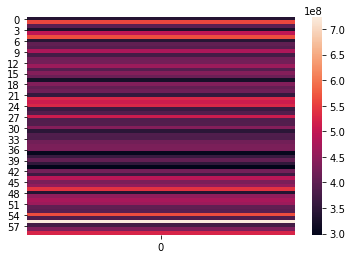

In [14]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(666887.5625, device='cuda:0')
tensor(31.8088, device='cuda:0')


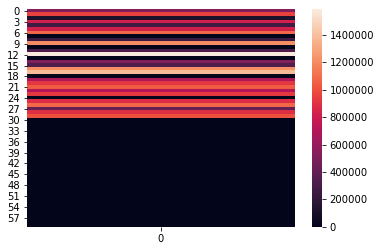

In [15]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(10997.4629, device='cuda:0')
tensor(522.5376, device='cuda:0')


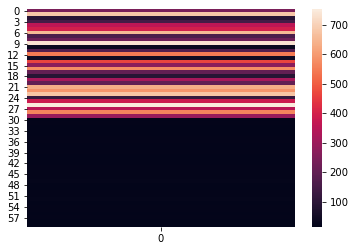

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2879.9937, device='cuda:0')
tensor(0.0063, device='cuda:0')


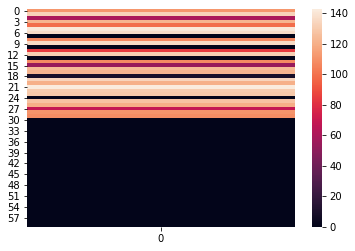

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)]

tensor([1.1180e+02, 1.3306e+02, 6.0280e+01, 1.2249e+02, 9.9101e+01, 1.4094e+02,
        1.3757e+02, 4.1213e-15, 1.0705e+02, 1.3629e+02, 1.0501e-08, 8.4122e+01,
        1.3240e+02, 1.9941e+00, 1.0833e+02, 5.4244e+01, 1.2476e+02, 1.2238e+02,
        8.9732e+00, 1.3396e+02, 1.2066e+02, 1.4261e+02, 1.3090e+02, 1.2935e+02,
        9.5645e-01, 1.2712e+02, 1.2000e+02, 6.8564e+01, 1.1094e+02, 1.0914e+02],
       device='cuda:0')

In [19]:
subset_indices_post_burnin[(D):]

tensor([1.6597e-05, 6.6677e-23, 7.8887e-16, 5.5094e-17, 1.8915e-23, 1.8068e-19,
        8.9318e-21, 6.5295e-20, 1.9533e-25, 6.2159e-03, 9.5017e-05, 1.0084e-10,
        5.7757e-17, 6.9492e-28, 2.2657e-21, 8.6651e-19, 1.3383e-23, 5.1032e-27,
        8.1666e-16, 1.4619e-16, 3.1992e-28, 1.0044e-27, 4.8661e-23, 4.7717e-19,
        1.4917e-21, 4.2972e-34, 2.4594e-22, 5.5718e-22, 2.4387e-22, 5.4606e-23],
       device='cuda:0')

In [20]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2879.9873, device='cuda:0')

In [21]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [22]:
sum(top_ind < 30)

tensor(24, device='cuda:0')

In [23]:
sum(top_ind >= 30)

tensor(0, device='cuda:0')

In [24]:
vae_gumbel_truncated.logit_enc

tensor([[ 4.6346,  6.2254,  3.1456,  5.9084,  4.4441,  8.7351,  8.0707,  0.1048,
          4.1561,  9.5264,  0.1322,  4.1212, 10.5024,  0.7616,  4.7986,  3.2178,
          6.9503,  5.2929,  2.0909,  7.5077,  5.7181,  9.2071, 12.4159, 12.8528,
          0.5841,  7.6502, 21.3944,  3.6893,  4.8685,  4.4639, -0.3449, -0.0946,
         -0.1178, -0.2080, -0.2338, -0.0882, -0.1054, -0.1083, -0.2241, -0.0749,
         -0.1138, -0.1215, -0.1309, -0.1090, -0.1153, -0.0795, -0.1255, -0.1243,
         -0.1183, -0.1165, -0.1187, -0.1096, -0.1282, -0.0726, -0.0994, -0.0871,
         -0.1515, -0.1474, -0.1030, -0.2300]], device='cuda:0')

In [25]:
vae_gumbel_truncated.weight_creator(train_data[64:128, ]).mean(dim = 0)

tensor([ 4.6186,  6.2223,  3.1395,  5.8893,  4.4262,  8.7137,  8.0437,  0.0999,
         4.1529,  9.5030,  0.1314,  4.1048, 10.4765,  0.7549,  4.7832,  3.2178,
         6.9146,  5.2851,  2.0739,  7.4715,  5.6973,  9.1733, 12.3761, 12.8058,
         0.5793,  7.6275, 21.3061,  3.6789,  4.8518,  4.4516, -0.3438, -0.0943,
        -0.1173, -0.2073, -0.2331, -0.0879, -0.1051, -0.1080, -0.2235, -0.0746,
        -0.1134, -0.1211, -0.1305, -0.1087, -0.1149, -0.0793, -0.1250, -0.1240,
        -0.1180, -0.1160, -0.1183, -0.1092, -0.1278, -0.0724, -0.0991, -0.0868,
        -0.1510, -0.1469, -0.1026, -0.2293], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [26]:
sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t)



tensor([[9.9295e-01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 9.9843e-01, 1.0000e+00,
         9.9910e-01, 0.0000e+00, 1.8459e-40, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0001e+00, 9.9987e-01, 1.0000e+00,
         1.0000e+00, 1.0009e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0016e+00, 1.0070e+00,
         1.4203e-26, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.7378e-42, 0.0000e+00, 3.5942e-29, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 6.3351e-18, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7132e-21,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0812e-07, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')